In [3]:
!pip install transformers datasets evaluate peft nltk rouge-score bert_score pandas matplotlib seaborn tqdm --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00


In [4]:
# Import essential libraries
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from peft import get_peft_model, LoraConfig, TaskType
import evaluate
from tqdm.auto import tqdm

In [5]:
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

# Create project directory
!mkdir -p /content/drive/MyDrive/financial_summarization
PROJECT_DIR = '/content/drive/MyDrive/financial_summarization'

Mounted at /content/drive


## Dataset Preparation
Dataset Loading and Analysis

In [12]:
print("Loading CNN/DailyMail dataset...")
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")
print(f"Dataset loaded: {len(dataset['train'])} train, {len(dataset['validation'])} validation, {len(dataset['test'])} test")

# Examine a few examples
print("\nSample article:")
print(dataset['train'][0]['article'][:500] + "...")
print("\nSample summary:")
print(dataset['train'][0]['highlights'])

Loading CNN/DailyMail dataset...
Dataset loaded: 287113 train, 13368 validation, 11490 test

Sample article:
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as s...

Sample summary:
Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


## Analyze dataset statistics


Dataset Statistics (train split):
Article Length:
  Mean: 591.62
  Median: 547.00
  Min: 50.00
  Max: 1743.00
  Std: 286.52
Summary Length:
  Mean: 42.77
  Median: 43.00
  Min: 23.00
  Max: 66.00
  Std: 7.55


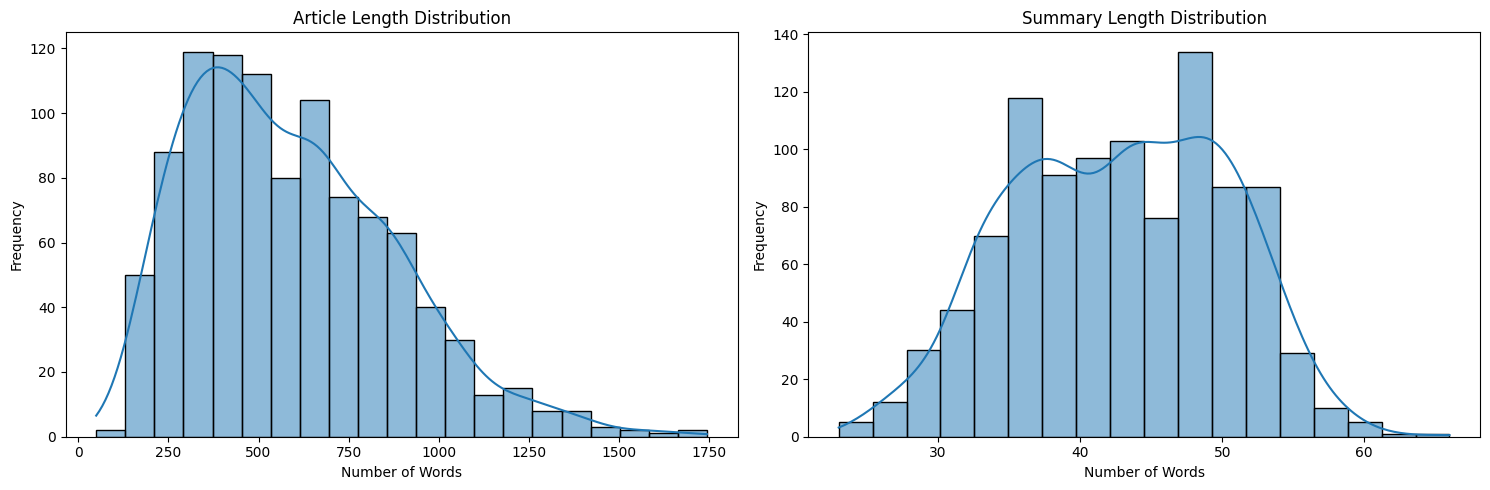

In [13]:
def analyze_dataset_statistics(dataset, split='train', sample_size=1000):
    """Analyze and visualize dataset statistics"""

    # Select a sample for faster processing
    if len(dataset[split]) > sample_size:
        sample = dataset[split].select(range(sample_size))
    else:
        sample = dataset[split]

    # Compute article and summary lengths
    article_lengths = [len(example['article'].split()) for example in sample]
    summary_lengths = [len(example['highlights'].split()) for example in sample]

    # Calculate statistics
    stats = {
        'Article Length': {
            'Mean': np.mean(article_lengths),
            'Median': np.median(article_lengths),
            'Min': np.min(article_lengths),
            'Max': np.max(article_lengths),
            'Std': np.std(article_lengths)
        },
        'Summary Length': {
            'Mean': np.mean(summary_lengths),
            'Median': np.median(summary_lengths),
            'Min': np.min(summary_lengths),
            'Max': np.max(summary_lengths),
            'Std': np.std(summary_lengths)
        }
    }

    print(f"\nDataset Statistics ({split} split):")
    for metric, values in stats.items():
        print(f"{metric}:")
        for stat_name, stat_value in values.items():
            print(f"  {stat_name}: {stat_value:.2f}")

    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Article length distribution
    sns.histplot(article_lengths, kde=True, ax=axes[0])
    axes[0].set_title('Article Length Distribution')
    axes[0].set_xlabel('Number of Words')
    axes[0].set_ylabel('Frequency')

    # Summary length distribution
    sns.histplot(summary_lengths, kde=True, ax=axes[1])
    axes[1].set_title('Summary Length Distribution')
    axes[1].set_xlabel('Number of Words')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/dataset_statistics_{split}.png")
    plt.show()

    return stats

# Analyze train split
train_stats = analyze_dataset_statistics(dataset, 'train')

### Finance-Specific Filtering

Define finance keywords

In [16]:
def define_finance_keywords():
    """Define comprehensive financial keyword list"""

    # General financial terms
    general_finance = [
        'stock', 'market', 'investor', 'economy', 'financial', 'economic',
        'bank', 'trading', 'investment', 'profit', 'revenue', 'earnings',
        'fiscal', 'dividend', 'shareholders', 'ceo', 'quarterly', 'hedge',
        'fund', 'debt', 'credit', 'loan', 'mortgage', 'bond', 'yield',
        'interest rate', 'inflation', 'recession', 'gdp', 'growth'
    ]

    # Financial entities and organizations
    organizations = [
        'nasdaq', 'dow jones', 'nyse', 's&p', 'fed', 'federal reserve',
        'sec', 'imf', 'world bank', 'treasury', 'wall street', 'moody',
        'fitch', 'standard & poor', 'bloomberg', 'goldman sachs', 'jpmorgan',
        'morgan stanley', 'citigroup', 'bank of america', 'wells fargo'
    ]

    # Financial metrics and indicators
    metrics = [
        'eps', 'p/e', 'price-to-earnings', 'market cap', 'capitalization',
        'valuation', 'undervalued', 'overvalued', 'bull', 'bear', 'bullish',
        'bearish', 'volatility', 'index', 'benchmark', 'portfolio', 'asset',
        'liability', 'balance sheet', 'income statement', 'cash flow'
    ]

    # Currencies and commodities
    currencies_commodities = [
        'dollar', 'euro', 'yen', 'pound', 'forex', 'currency', 'exchange rate',
        'oil', 'gold', 'silver', 'commodity', 'futures', 'barrel', 'crude'
    ]

    # Earnings & corporate actions
    earnings_actions = [
        'earnings call', 'quarterly results', 'buyback', 'stock split', 'ipo',
        'spinoff', 'guidance', 'outlook', 'forecast', 'merger', 'acquisition',
        'm&a', 'sec filing', '10-k', '10-q', 'report', 'filing', 'upgrade', 'downgrade'
    ]

    # People & roles
    people_roles = [
        'analyst', 'board', 'chairman', 'cfo', 'cio', 'coo', 'founder', 'investor relations'
    ]

    # Market events & trends
    events_trends = [
        'bull run', 'market crash', 'correction', 'bubble', 'slump', 'rally',
        'downturn', 'soft landing', 'tightening', 'easing', 'macroeconomic',
        'stimulus', 'policy rate'
    ]

    # Global & political factors
    global_politics = [
        'tariff', 'sanctions', 'brexit', 'trade war', 'geopolitical', 'central bank', 'opec'
    ]

    # Tech & fintech
    fintech_terms = [
        'blockchain', 'crypto', 'bitcoin', 'ethereum', 'digital currency', 'fintech', 'neobank'
    ]

    # Abbreviations and tickers
    abbreviations = [
        'ipo', 'etf', 'cpi', 'ppi', 'fomc', 'gdp', 'usd', 'eur', 'jpy'
    ]

    # Merge all categories
    all_keywords = (
        general_finance + organizations + metrics + currencies_commodities +
        earnings_actions + people_roles + events_trends + global_politics +
        fintech_terms + abbreviations
    )

    # Add uppercase and title case versions for robustness
    expanded_keywords = all_keywords.copy()
    for keyword in all_keywords:
        expanded_keywords.append(keyword.upper())
        expanded_keywords.append(keyword.title())

    return list(set(expanded_keywords))  # Remove duplicates

# Generate finance keywords
finance_keywords = define_finance_keywords()
print(f"Created list of {len(finance_keywords)} finance keywords")
print("Sample keywords:", finance_keywords[:10])


Created list of 436 finance keywords
Sample keywords: ['crypto', 'financial', 'Stock', 'BUYBACK', 'SANCTIONS', 'cash flow', 'MERGER', 'bloomberg', 'BOARD', 'BLOOMBERG']


#### Create finance filtering function:

In [17]:
def is_finance_related(article, keywords=finance_keywords, min_matches=2):
    """
    Determine if an article is finance-related based on keyword matching

    Args:
        article (str): Article text
        keywords (list): List of finance-related keywords
        min_matches (int): Minimum number of keyword matches required

    Returns:
        bool: True if article is finance-related, False otherwise
    """
    article_lower = article.lower()
    match_count = 0

    for keyword in keywords:
        if keyword.lower() in article_lower:
            match_count += 1
            if match_count >= min_matches:
                return True

    return False

# Test the filter on a few examples
for i in range(5):
    article = dataset['train'][i]['article']
    is_finance = is_finance_related(article)
    print(f"Example {i+1}: {'Finance-related' if is_finance else 'Not finance-related'}")
    if is_finance:
        # Find which keywords matched
        matched = [k for k in finance_keywords if k.lower() in article.lower()]
        print(f"  Matched keywords: {matched[:5]}")

Example 1: Finance-related
  Matched keywords: ['REPORT', 'Report', 'earnings', 'POUND', 'FUND']
Example 2: Not finance-related
Example 3: Finance-related
  Matched keywords: ['SEC', 'Ppi', 'bank', 'Bank', 'Sec']
Example 4: Finance-related
  Matched keywords: ['SEC', 'cio', 'CIO', 'Sec', 'Cio']
Example 5: Finance-related
  Matched keywords: ['REPORT', 'Report', 'SEC', 'fed', 'Fed']


#### Apply finance filter to dataset:

In [18]:
def filter_finance_articles(dataset, split='train', keywords=finance_keywords):
    """Filter dataset for finance-related articles"""

    def is_finance(example):
        return is_finance_related(example['article'], keywords)

    # Apply filter
    filtered_dataset = dataset[split].filter(is_finance)

    print(f"Finance filtering results for {split} split:")
    print(f"  Original size: {len(dataset[split])}")
    print(f"  Filtered size: {len(filtered_dataset)}")
    print(f"  Percentage: {len(filtered_dataset)/len(dataset[split])*100:.2f}%")

    return filtered_dataset

# Filter training set
train_finance = filter_finance_articles(dataset, 'train')
# Filter validation and test sets
val_finance = filter_finance_articles(dataset, 'validation')
test_finance = filter_finance_articles(dataset, 'test')

# Sample up to 4000 examples for training to keep computation manageable
TRAIN_SAMPLE_SIZE = min(4000, len(train_finance))
VAL_SAMPLE_SIZE = min(500, len(val_finance))
TEST_SAMPLE_SIZE = min(500, len(test_finance))

# Create stratified sample (balance longer and shorter articles)
def create_balanced_sample(dataset, size):
    article_lengths = [len(example['article'].split()) for example in dataset]
    # Create bins for article length
    median_length = np.median(article_lengths)
    short_indices = [i for i, length in enumerate(article_lengths) if length <= median_length]
    long_indices = [i for i, length in enumerate(article_lengths) if length > median_length]

    # Sample evenly from short and long articles
    short_sample = np.random.choice(short_indices, size=size//2, replace=False)
    long_sample = np.random.choice(long_indices, size=size//2, replace=False)

    # Combine indices and sort
    combined_indices = sorted(list(short_sample) + list(long_sample))
    return dataset.select(combined_indices)

# Create balanced samples
train_dataset = create_balanced_sample(train_finance, TRAIN_SAMPLE_SIZE)
val_dataset = create_balanced_sample(val_finance, VAL_SAMPLE_SIZE)
test_dataset = create_balanced_sample(test_finance, TEST_SAMPLE_SIZE)

print(f"Final dataset sizes: {len(train_dataset)} train, {len(val_dataset)} validation, {len(test_dataset)} test")

# Save datasets to disk for persistence
train_dataset.save_to_disk(f"{PROJECT_DIR}/train_finance")
val_dataset.save_to_disk(f"{PROJECT_DIR}/val_finance")
test_dataset.save_to_disk(f"{PROJECT_DIR}/test_finance")

Filter:   0%|          | 0/287113 [00:00<?, ? examples/s]

Finance filtering results for train split:
  Original size: 287113
  Filtered size: 270593
  Percentage: 94.25%


Filter:   0%|          | 0/13368 [00:00<?, ? examples/s]

Finance filtering results for validation split:
  Original size: 13368
  Filtered size: 12333
  Percentage: 92.26%


Filter:   0%|          | 0/11490 [00:00<?, ? examples/s]

Finance filtering results for test split:
  Original size: 11490
  Filtered size: 10565
  Percentage: 91.95%
Final dataset sizes: 4000 train, 500 validation, 500 test


Saving the dataset (0/1 shards):   0%|          | 0/4000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

# Data Cleaning and Preprocessing

#### Define preprocessing functions

In [22]:
import re

def preprocess_example(example):
    """Clean and normalize article and summary text for financial summarization."""

    # Normalize whitespace and lowercase
    article = ' '.join(example["article"].split()).lower()
    summary = ' '.join(example["highlights"].split()).lower()

    # Fix punctuation spacing
    for punct in ['.', ',', '!', '?', ';', ':', '%']:
        article = article.replace(f" {punct}", punct)
        summary = summary.replace(f" {punct}", punct)

    # Replace dollar variants with standard symbol
    for symbol in ["$", "us$", "usd"]:
        article = article.replace(symbol, " $ ")
        summary = summary.replace(symbol, " $ ")

    # Replace monetary values with <MONEY> placeholder
    article = re.sub(r"\$\s?\d+([\.,]?\d+)*", "<MONEY>", article)
    summary = re.sub(r"\$\s?\d+([\.,]?\d+)*", "<MONEY>", summary)

    # Remove control characters
    article = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', article)
    summary = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', summary)

    # Final cleanup of extra spaces
    article = ' '.join(article.split())
    summary = ' '.join(summary.split())

    return {
        "article": article.strip(),
        "summary": summary.strip(),
        "id": example["id"]
    }
    # Apply preprocessing to all datasets
print("Preprocessing datasets...")
train_dataset = train_dataset.map(preprocess_example)
val_dataset = val_dataset.map(preprocess_example)
test_dataset = test_dataset.map(preprocess_example)

# Check a preprocessed example
print("\nPreprocessed example:")
print("Article (first 200 chars):", train_dataset[0]["article"][:200] + "...")
print("Summary:", train_dataset[0]["summary"])


Preprocessing datasets...


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]


Preprocessed example:
Article (first 200 chars): reuters is a global information company providing material tailored for professionals in the financial services, media and corporate markets. its information is trusted and drives decision making acro...
Summary: reuters was founded in 1851 by julius reuter, transmitting market quotations. the company was first in europe with news of president lincoln's assassination. today reuters has 196 bureaux serving approximately 131 countries.


#### Analyze financial entity distribution:


Financial Entity Analysis (train split, sample of 100):
  percentage: 2 occurrences (0.02 per article)
    Examples: ['90%', '10%']
  dollar_amount: 90 occurrences (0.90 per article)
    Examples: ['$ 275,000', '$ 4 million', '$ 350,000', '$ 250', '$ 300']
  financial_year: 0 occurrences (0.00 per article)
  growth_rate: 0 occurrences (0.00 per article)


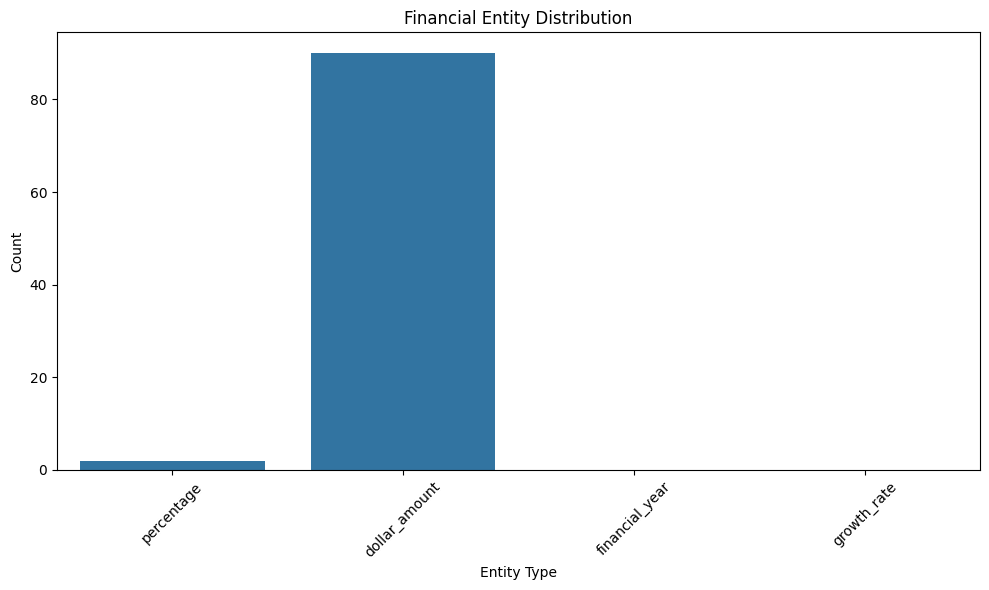

In [23]:
def extract_financial_entities(dataset, split='train', sample_size=100):
    """Extract and analyze financial entities in the dataset"""

    # Select sample for analysis
    if len(dataset) > sample_size:
        sample = dataset.select(range(sample_size))
    else:
        sample = dataset

    # Define financial entity patterns
    import re

    patterns = {
        'percentage': r'\d+(?:\.\d+)?%',
        'dollar_amount': r'\$\s?\d+(?:,\d+)*(?:\.\d+)?(?:\s?(?:million|billion|trillion))?',
        'financial_year': r'(?:FY|Q[1-4])[-\s]?\d{2,4}',
        'growth_rate': r'(?:grew|increased|decreased|declined|dropped)(?:\s+by)?\s+\d+(?:\.\d+)?%',
    }

    entity_counts = {entity_type: 0 for entity_type in patterns}
    entity_examples = {entity_type: [] for entity_type in patterns}

    for example in sample:
        article = example['article']
        for entity_type, pattern in patterns.items():
            matches = re.findall(pattern, article)
            entity_counts[entity_type] += len(matches)
            entity_examples[entity_type].extend(matches[:5])  # Store up to 5 examples

    print(f"\nFinancial Entity Analysis ({split} split, sample of {len(sample)}):")
    for entity_type, count in entity_counts.items():
        print(f"  {entity_type}: {count} occurrences ({count/len(sample):.2f} per article)")
        if entity_examples[entity_type]:
            print(f"    Examples: {entity_examples[entity_type][:5]}")

    # Create visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
    plt.title('Financial Entity Distribution')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/financial_entities_{split}.png")
    plt.show()

    return entity_counts, entity_examples

# Analyze financial entities in training set
train_entities, train_entity_examples = extract_financial_entities(train_dataset)

#### Save preprocessed datasets:

In [24]:
# Save final preprocessed datasets
print("Saving preprocessed datasets...")
train_dataset.save_to_disk(f"{PROJECT_DIR}/train_finance_preprocessed")
val_dataset.save_to_disk(f"{PROJECT_DIR}/val_finance_preprocessed")
test_dataset.save_to_disk(f"{PROJECT_DIR}/test_finance_preprocessed")

# Save dataset statistics and analysis results
import json

analysis_results = {
    'dataset_stats': {
        'train': {
            'size': len(train_dataset),
            'article_mean_length': train_stats['Article Length']['Mean'],
            'summary_mean_length': train_stats['Summary Length']['Mean'],
        },
        'validation': {
            'size': len(val_dataset),
        },
        'test': {
            'size': len(test_dataset),
        }
    },
    'financial_entities': {
        entity_type: count for entity_type, count in zip(train_entities.keys(), train_entities.values())
    },
    'preprocessing': {
        'finance_keywords_used': len(finance_keywords),
        'original_train_size': len(dataset['train']),
        'finance_filtered_size': len(train_finance),
        'finance_percentage': len(train_finance)/len(dataset['train'])*100
    }
}

with open(f"{PROJECT_DIR}/dataset_analysis.json", 'w') as f:
    json.dump(analysis_results, f, indent=2)

print("Phase 1 completed! Dataset prepared and analyzed.")

Saving preprocessed datasets...


Saving the dataset (0/1 shards):   0%|          | 0/4000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Phase 1 completed! Dataset prepared and analyzed.


# Exploratory Data Visualization

#### Explore article-summary relationship

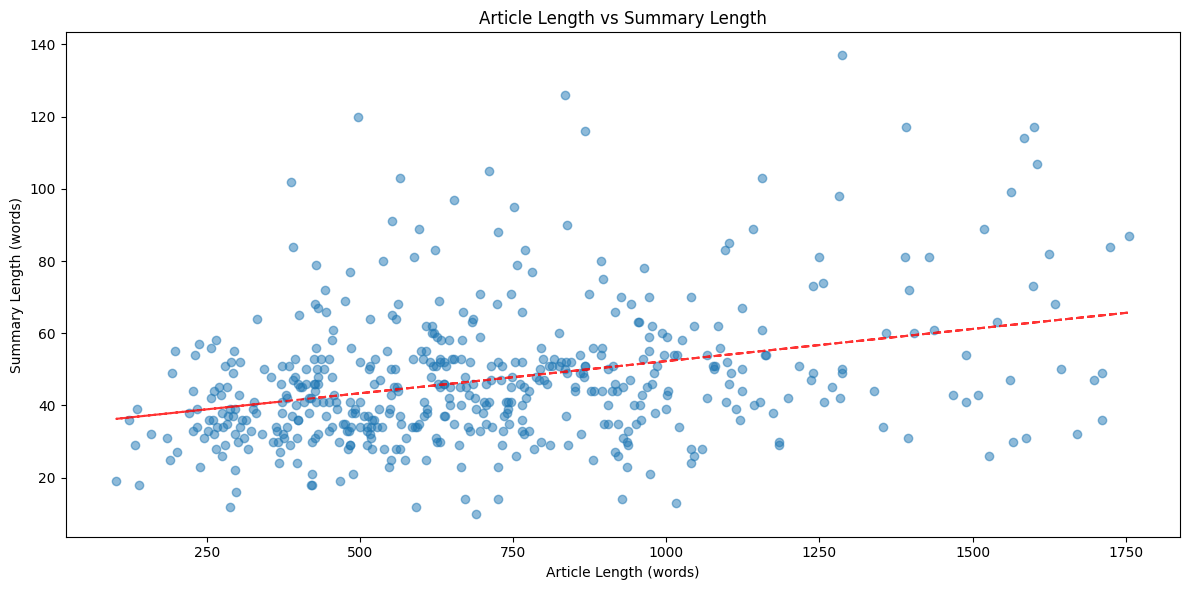

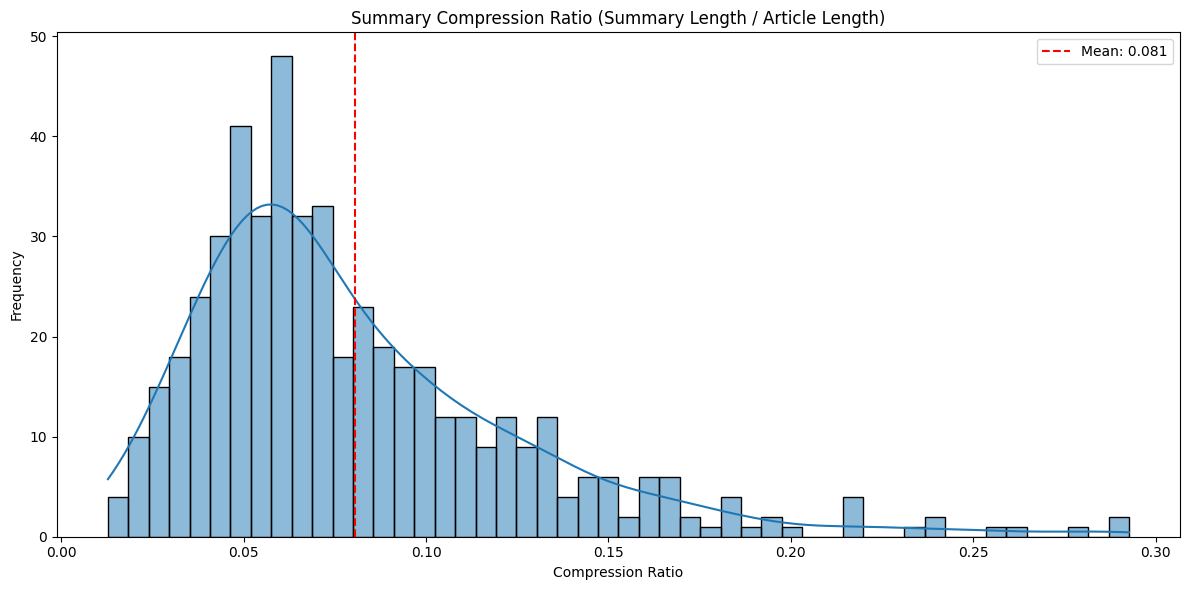

Article-Summary Relationship Stats: {'mean_compression_ratio': np.float64(0.08064717767848255), 'median_compression_ratio': np.float64(0.06782094910437156), 'correlation': np.float64(0.32818429189336396)}


In [25]:
def visualize_article_summary_relationship(dataset, sample_size=500):
    """Visualize relationship between article and summary lengths"""

    # Select sample
    if len(dataset) > sample_size:
        indices = np.random.choice(len(dataset), size=sample_size, replace=False)
        sample = dataset.select(indices)
    else:
        sample = dataset

    # Compute lengths
    article_lengths = [len(example['article'].split()) for example in sample]
    summary_lengths = [len(example['summary'].split()) for example in sample]
    compression_ratios = [s/a if a > 0 else 0 for s, a in zip(summary_lengths, article_lengths)]

    # Create scatter plot
    plt.figure(figsize=(12, 6))
    plt.scatter(article_lengths, summary_lengths, alpha=0.5)
    plt.title('Article Length vs Summary Length')
    plt.xlabel('Article Length (words)')
    plt.ylabel('Summary Length (words)')

    # Add trend line
    z = np.polyfit(article_lengths, summary_lengths, 1)
    p = np.poly1d(z)
    plt.plot(article_lengths, p(article_lengths), "r--", alpha=0.8)

    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/article_summary_relationship.png")
    plt.show()

    # Compression ratio histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(compression_ratios, bins=50, kde=True)
    plt.title('Summary Compression Ratio (Summary Length / Article Length)')
    plt.xlabel('Compression Ratio')
    plt.ylabel('Frequency')
    plt.axvline(np.mean(compression_ratios), color='red', linestyle='--',
               label=f'Mean: {np.mean(compression_ratios):.3f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/compression_ratio.png")
    plt.show()

    return {
        'mean_compression_ratio': np.mean(compression_ratios),
        'median_compression_ratio': np.median(compression_ratios),
        'correlation': np.corrcoef(article_lengths, summary_lengths)[0, 1]
    }

# Analyze article-summary relationship
relationship_stats = visualize_article_summary_relationship(train_dataset)
print("Article-Summary Relationship Stats:", relationship_stats)

#### Prepare a dataset report

In [26]:
def generate_dataset_report(train_dataset, val_dataset, test_dataset, train_stats, relationship_stats):
    """Generate comprehensive dataset report with findings"""

    report = f"""
# Financial News Summarization Dataset Report

## Dataset Overview

- **Source**: CNN/DailyMail dataset filtered for financial content
- **Size**:
    - Training: {len(train_dataset)} examples
    - Validation: {len(val_dataset)} examples
    - Test: {len(test_dataset)} examples
- **Finance Filtering**: Used {len(finance_keywords)} financial keywords, requiring at least 2 matches

## Data Characteristics

### Article Statistics
- Mean Length: {train_stats['Article Length']['Mean']:.2f} words
- Median Length: {train_stats['Article Length']['Median']:.2f} words
- Min Length: {train_stats['Article Length']['Min']:.2f} words
- Max Length: {train_stats['Article Length']['Max']:.2f} words

### Summary Statistics
- Mean Length: {train_stats['Summary Length']['Mean']:.2f} words
- Median Length: {train_stats['Summary Length']['Median']:.2f} words
- Min Length: {train_stats['Summary Length']['Min']:.2f} words
- Max Length: {train_stats['Summary Length']['Max']:.2f} words

### Article-Summary Relationship
- Mean Compression Ratio: {relationship_stats['mean_compression_ratio']:.3f}
- Correlation between Article and Summary Length: {relationship_stats['correlation']:.3f}

## Financial Content Analysis

### Financial Entity Distribution
"""

    for entity_type, count in train_entities.items():
        report += f"- {entity_type}: {count} occurrences ({count/len(train_dataset):.2f} per article)\n"

    report += """
## Preprocessing Steps

1. Filtered for finance-related content using keyword matching
2. Removed duplicate whitespace and normalized text
3. Fixed punctuation spacing
4. Normalized financial symbols (e.g., standardized $ formats)
5. Created balanced samples with respect to article length

## Implications for Model Training

- The average summary is approximately {relationship_stats['mean_compression_ratio']:.1%} of the article length
- Based on length distributions, we should set maximum input length to 512 tokens
- For output/summary length, 128 tokens should be sufficient for most examples
- Financial entities (percentages, dollar amounts) should be preserved in summaries
"""

    # Save report to file
    with open(f"{PROJECT_DIR}/dataset_report.md", 'w') as f:
        f.write(report)

    print("Dataset report generated and saved to:", f"{PROJECT_DIR}/dataset_report.md")
    return report

# Generate comprehensive report
dataset_report = generate_dataset_report(train_dataset, val_dataset, test_dataset,
                                       train_stats, relationship_stats)
print("\nDataset Report Preview:")
print(dataset_report[:500] + "...")

Dataset report generated and saved to: /content/drive/MyDrive/financial_summarization/dataset_report.md

Dataset Report Preview:

# Financial News Summarization Dataset Report

## Dataset Overview

- **Source**: CNN/DailyMail dataset filtered for financial content
- **Size**: 
    - Training: 4000 examples
    - Validation: 500 examples
    - Test: 500 examples
- **Finance Filtering**: Used 436 financial keywords, requiring at least 2 matches

## Data Characteristics

### Article Statistics
- Mean Length: 591.62 words
- Median Length: 547.00 words
- Min Length: 50.00 words
- Max Length: 1743.00 words

### Summary Statisti...
